**Tracking Unique Insect Species in the City of Melbourne**

Authored by: Rohang Shah
Duration: 90 mins
Level: Intermediate
Pre-requisite Skills: Python, Data Analysis, Geospatial Analysis


In the context of urban biodiversity, tracking the presence and distribution of unique insect species can significantly aid in conservation efforts. This use case focuses on identifying and monitoring areas within the City of Melbourne where certain insect species are found uniquely, compared to other areas. By analyzing the insect records collected from the Little Things that Run the City Project and subsequent Melbourne BioBlitz events, the City of Melbourne can pinpoint locations where rare or unique insect species are present. This enables the city to focus conservation efforts on these critical areas to protect and preserve these species and their habitats.

**What this Use Case Will Teach You**
At the end of this use case, you will:

*   Learn how to access and manipulate City of Melbourne Open Data.
*   Develop skills in geospatial data analysis.
*   Gain experience in identifying patterns and anomalies in biodiversity data.
*   Understand how to use data analysis to inform conservation strategies.


**Introduction or Background**
Urbanization poses a significant threat to biodiversity. The City of Melbourne, through projects like the Little Things that Run the City and Melbourne BioBlitz events, has collected valuable data on insect species within the city. This data can be leveraged to identify and protect unique insect species and their habitats. By focusing conservation efforts on areas where these species are found, the City of Melbourne can enhance its biodiversity and ensure the sustainability of its ecosystems.


**User Story**
Title: Protecting Melbourne's Unique Insect Species
As a conservation biologist working with the City of Melbourne, I want to identify and monitor areas within the city where certain insect species are uniquely found so that I can focus conservation efforts on these critical habitats to protect and preserve these species and their ecosystems.

**Scenario**
The City of Melbourne has been collecting insect data through the "Little Things that Run the City" project and the Melbourne BioBlitz events. This data includes observations of various insect species across different locations in the city. As a conservation biologist, my goal is to analyze this data to pinpoint areas with unique insect species that are not found elsewhere. By identifying these critical habitats, the city can prioritize conservation efforts, allocate resources effectively, and develop strategies to protect these unique species from urban development and other threats.







Importing libraries and defining a function to download datasets from Melbourne Open Data portal.

You set up libraries like pandas, geopandas, folium, and define a collect_data() function to download datasets.

In [ ]:
import pandas as pd
import requests
from io import StringIO
import geopandas as gpd
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from IPython.display import IFrame, display
from tabulate import tabulate



# Function to collect and return a single dataset
def collect_data(dataset_id, apikey=""):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'

    url = f'{base_url}{dataset_id}/{suffix}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    df = pd.read_csv(StringIO(response.text), delimiter=';')
    return df

# List of all dataset IDs
DATASET_IDS = [
    'insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city',
    'wildlife-sightings-bioblitz-2014',
    'bioblitz-2016'
]

# Optional: API key
API_KEY = ""

# Collect and combine all datasets
all_dataframes = []

for dataset_id in DATASET_IDS:
    df = collect_data(dataset_id, apikey=API_KEY)
    df['source_dataset'] = dataset_id  # Add a column to track which dataset the data came from
    all_dataframes.append(df)

# Combine into a single DataFrame
df_all = pd.concat(all_dataframes, ignore_index=True)

# Show info about combined dataset
print("Combined DataFrame Info:")
print(tabulate(df_all.info(), headers='keys', tablefmt='psql'))

print("\nDataFrame Description:")
print(tabulate(df_all.describe(include='all'), headers='keys', tablefmt='psql'))

print("\nFirst 5 Rows of Combined DataFrame:")
print(tabulate(df_all.head(), headers='keys', tablefmt='psql'))


Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   taxa                  3318 non-null   object 
 1   kingdom               3318 non-null   object 
 2   phylum                3287 non-null   object 
 3   class                 3279 non-null   object 
 4   order                 3141 non-null   object 
 5   family                3096 non-null   object 
 6   genus                 2208 non-null   object 
 7   species               1769 non-null   object 
 8   identification_notes  1669 non-null   object 
 9   location              1963 non-null   object 
 10  sighting_date         1963 non-null   object 
 11  source_dataset        3321 non-null   object 
 12  common_name           1457 non-null   object 
 13  data_resource_name    2026 non-null   object 
 14  latitude              2024 non-null   float64
 

Displaying number of records in the current dataset.

Prints the number of rows (records) present in the loaded dataset.



Printing column names of the dataset.

Displays all column headers to help understand dataset structure.

In [ ]:

num_records = df.shape[0]
print(f"Number of records in the dataset: {num_records}")


Number of records in the dataset: 1356


Printing column names of the dataset.

Displays all column headers to help understand dataset structure.

In [ ]:

print("Column Names:")
print(df.columns)


Column Names:
Index(['taxa', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'species', 'common_name', 'identification_notes', 'data_resource_name',
       'sighting_date', 'latitude', 'longitude', 'location', 'geopoint',
       'source_dataset'],
      dtype='object')


🧭 Extracting latitude and longitude from 'location' column.
A function tries to extract latitude and longitude values from the location string field.

In [ ]:
# First, make a fresh copy from the combined dataset
df = df_all.copy()

# Use 'geopoint' to extract lat/lon if available
def extract_from_geopoint(geo):
    try:
        lat, lon = map(float, geo.split(','))
        return pd.Series([lat, lon])
    except:
        return pd.Series([None, None])

df[['latitude', 'longitude']] = df['geopoint'].apply(extract_from_geopoint)

# Drop rows with missing coordinates
df_cleaned = df.dropna(subset=['latitude', 'longitude'])

# Drop rows with missing species
df_cleaned = df_cleaned[df_cleaned['species'].notnull()]

# Drop duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Display cleaned dataset info
print("\n✅ Cleaned DataFrame Info:")
print(df_cleaned.info())

# Confirm non-empty species
print("\nUnique species found:", df_cleaned['species'].nunique())



✅ Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 1975 to 3317
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   taxa                  846 non-null    object 
 1   kingdom               846 non-null    object 
 2   phylum                846 non-null    object 
 3   class                 846 non-null    object 
 4   order                 846 non-null    object 
 5   family                846 non-null    object 
 6   genus                 846 non-null    object 
 7   species               846 non-null    object 
 8   identification_notes  101 non-null    object 
 9   location              0 non-null      object 
 10  sighting_date         845 non-null    object 
 11  source_dataset        846 non-null    object 
 12  common_name           802 non-null    object 
 13  data_resource_name    846 non-null    object 
 14  latitude              846 non-null    float64
 1

Data Analysis - Identifying unique species

Identifying all unique insect species from the cleaned data.
Prints the number and names of unique insect species after cleaning.



In [ ]:
# Identify unique insect species
unique_species = df_cleaned['species'].unique()

# Display number of unique species
num_unique_species = len(unique_species)
print(f"Number of unique insect species: {num_unique_species}")

# Display unique species names
print("Unique insect species names:")
print(unique_species)


Number of unique insect species: 370
Unique insect species names:
['ficifolia' 'leucoxylon' 'mearnsii' 'ewingii' 'spallanzanii' 'laticeps'
 'lucidoculatus' 'triangularis' 'polyphemus' 'minitabunda' 'excavata'
 'tibicen' 'molucca' 'jubata' 'melanophrys' 'porphyrio' 'castanea'
 'merula' 'tristis' 'lophotes' 'bergii' 'elegans' 'tenebrosa' 'modesta'
 'eximius' 'atra' 'montanus' 'carbo' 'torquatus' 'albiscapa' 'harmonica'
 'australis' 'poliocephalus' 'domesticus' 'novaeguineae' 'melanoleucos'
 'mellori' 'chrysoptera' 'tenuirostris' 'cyanoleuca' 'miles' 'caledonicus'
 'novaehollandiae' 'melanocephala' 'superciliosa' 'peregrinus' 'graculina'
 'haematodus' 'carunculata' 'haematonotus' 'livia' 'regia' 'chinensis'
 'punctatus' 'spinicollis' 'galerita' 'cyaneus' 'neoxena' 'penicillata'
 'leucophrys' 'maenas' 'laevis' 'serenus' 'scaber' 'deflexifrons' 'ovatus'
 'amurensis' 'holbrooki' 'bifrenatus' 'semifasciata' 'anolius'
 'tasmanianus' 'glaber' 'commune' 'luteola' 'mellifera' 'papuensis'
 'anactu

Spatial distribution

Converting cleaned data into a GeoDataFrame for spatial analysis.
Transforms your DataFrame into a spatially-aware format using geopandas for mapping.

In [ ]:
import geopandas as gpd

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_cleaned, geometry=gpd.points_from_xy(df_cleaned['longitude'], df_cleaned['latitude']))

# Display GeoDataFrame information
print("\nGeoDataFrame Info:")
print(gdf.info())

# Display first few rows of GeoDataFrame
print("\nFirst 5 Rows of GeoDataFrame:")
print(gdf.head())



GeoDataFrame Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 846 entries, 1975 to 3317
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   taxa                  846 non-null    object  
 1   kingdom               846 non-null    object  
 2   phylum                846 non-null    object  
 3   class                 846 non-null    object  
 4   order                 846 non-null    object  
 5   family                846 non-null    object  
 6   genus                 846 non-null    object  
 7   species               846 non-null    object  
 8   identification_notes  101 non-null    object  
 9   location              0 non-null      object  
 10  sighting_date         845 non-null    object  
 11  source_dataset        846 non-null    object  
 12  common_name           802 non-null    object  
 13  data_resource_name    846 non-null    object  
 14  latitude              846 non-n

Map visualization using folium

Converting cleaned data into a GeoDataFrame for spatial analysis.
(Repeated cell — same operation to enable folium visualization or clustering.)

In [ ]:
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt

# Use cleaned dataset
df_map = df_cleaned.dropna(subset=['latitude', 'longitude'])

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df_map, geometry=gpd.points_from_xy(df_map['longitude'], df_map['latitude']), crs="EPSG:4326")

# =========================
# 🗺️ 1. Insect Distribution Map
# =========================
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

for _, row in gdf.iterrows():
    popup = str(row['species']) if pd.notnull(row['species']) else "No species info"
    folium.Marker([row['latitude'], row['longitude']], popup=popup).add_to(m)

# Save HTML
m.save("insect_distribution_map.html")

# =========================
# 🧪 2. Clustering Map
# =========================
coords = gdf[['latitude', 'longitude']].values
db = DBSCAN(eps=0.01, min_samples=10).fit(coords)
gdf['cluster'] = db.labels_

m_clusters = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)
for _, row in gdf.iterrows():
    color = "red" if row['cluster'] == -1 else "blue"
    popup = str(row['species']) if pd.notnull(row['species']) else "No species info"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        popup=popup
    ).add_to(m_clusters)

# Save HTML
m_clusters.save("insect_clusters_map.html")
m  # Original distribution map

m_clusters  # Clustered map


Time series analysis

Plots a monthly timeline of insect sightings to observe temporal trends.



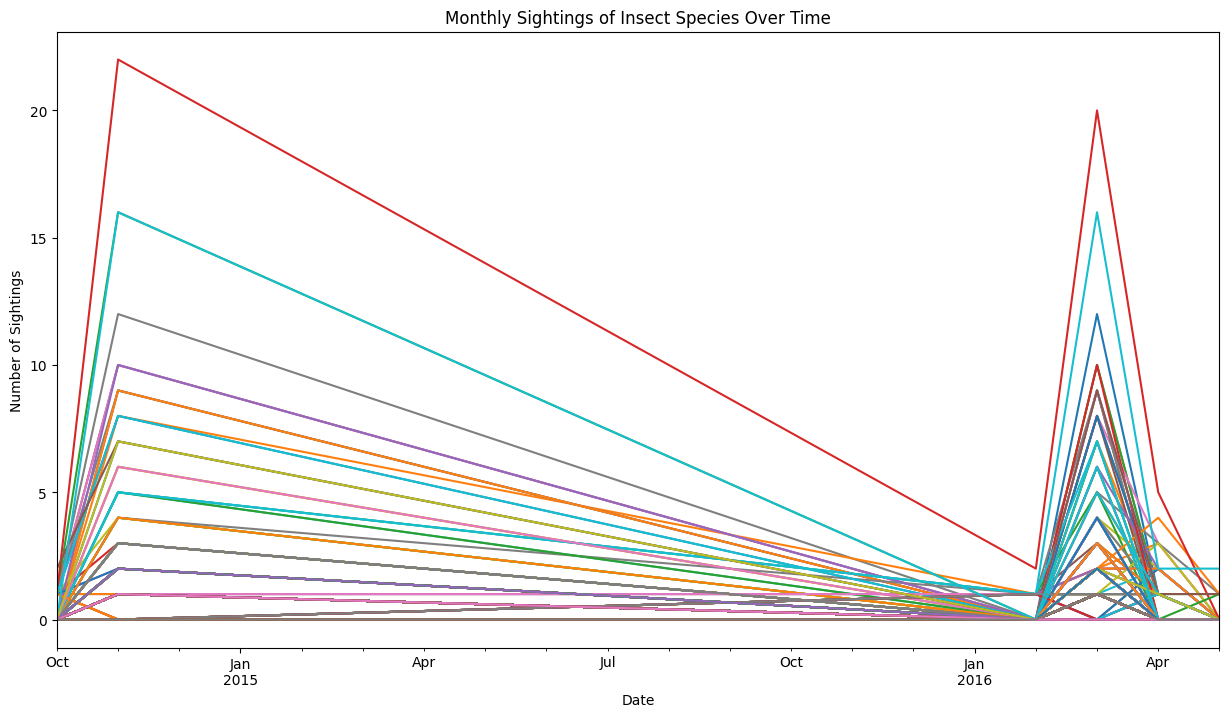

In [ ]:
import matplotlib.pyplot as plt


df['sighting_date'] = pd.to_datetime(df['sighting_date'], errors='coerce')
df = df.dropna(subset=['sighting_date'])

# Group by date and species, and count the number of sightings
time_series = df.groupby([df['sighting_date'].dt.to_period('M'), 'species']).size().unstack().fillna(0)

# Plot time series for selected species
time_series.plot(figsize=(15, 8), legend=False)
plt.title('Monthly Sightings of Insect Species Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sightings')
plt.show()



**Find Species Unique to One Location (Critical for Conservation)**

Identifies species that were recorded at only one unique location, helpful for conservation targeting.

In [ ]:
# Count how many unique locations each species was spotted in
species_location_counts = df_all.groupby('species')['location'].nunique()

# Filter species that appear in only ONE location
unique_species = species_location_counts[species_location_counts == 1].index.tolist()

# Get only those rows from the original dataset
unique_species_df = df_all[df_all['species'].isin(unique_species)]

# Show the result
print(f"Number of species unique to one location: {len(unique_species)}")
unique_species_df[['species', 'location']].drop_duplicates().head(10)


Number of species unique to one location: 258


,species,location
4,montrouzeri,State Library of Victoria
42,multispinosus,Royal Park
75,picticollis,Royal Park
107,schellenbergii,Carlton Gardens South
114,punctatum,Royal Park
122,callosus,Carlton Gardens South
123,undulata,Westgate Park
134,civica,Princes Park
144,discoideus,Princes Park
403,unicornuta,Royal Park


**Biodiversity Heatmap (Species Richness by Location)**

In [ ]:
# Load required libraries
import pandas as pd
import requests
from io import StringIO

def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'
    url = f'{base_url}{dataset_id}/{suffix}'
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(StringIO(response.text), delimiter=';')

# Dataset IDs
datasets = {
    "Little Things": "insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city",
    "BioBlitz 2014": "wildlife-sightings-bioblitz-2014",
    "BioBlitz 2016": "bioblitz-2016"
}

# Download and combine
dfs = []
for name, dataset_id in datasets.items():
    df = collect_data(dataset_id)
    df['source'] = name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Clean coordinates
if 'latitude' not in df_all.columns or 'longitude' not in df_all.columns:
    def extract_coordinates(location):
        try:
            location = location.strip('()')
            lat, lon = map(float, location.split(','))
            return pd.Series([lat, lon])
        except:
            return pd.Series([None, None])
    df_all[['latitude', 'longitude']] = df_all['location'].apply(extract_coordinates)

df_all = df_all.dropna(subset=['latitude', 'longitude'])
df_all['sighting_date'] = pd.to_datetime(df_all['sighting_date'], errors='coerce')


***Taxonomic Summary (Top Families / Orders / Genus)***

Prints and plots top 10 families and orders in the dataset.

Top 10 Families:
family
MELIPHAGIDAE    72
ANATIDAE        67
POACEAE         56
COLUMBIDAE      54
MYRTACEAE       53
RALLIDAE        43
ASTERACEAE      41
ARTAMIDAE       39
FORMICIDAE      38
FABACEAE        33
Name: count, dtype: int64

Top 10 Orders:
order
PASSERIFORMES    293
LEPIDOPTERA      168
POALES            79
HYMENOPTERA       78
ANSERIFORMES      67
DIPTERA           59
MYRTALES          57
COLUMBIFORMES     54
HEMIPTERA         54
ASPARAGALES       52
Name: count, dtype: int64


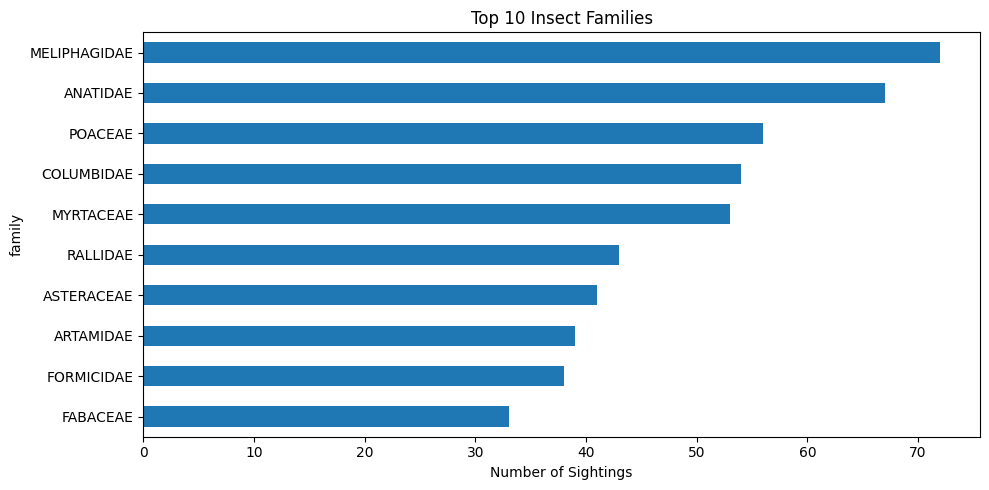

In [ ]:
 # Top 10 Families
print("Top 10 Families:")
print(df_all['family'].value_counts().head(10))

# Top 10 Orders
print("\nTop 10 Orders:")
print(df_all['order'].value_counts().head(10))

# Plot Top 10 Families
df_all['family'].value_counts().head(10).plot(kind='barh', title="Top 10 Insect Families", figsize=(10, 5))
plt.xlabel("Number of Sightings")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


***Seasonal Trends (Spring vs Summer vs Autumn vs Winter)***

Groups and visualizes insect sightings by season, helping you understand when insects are most active.

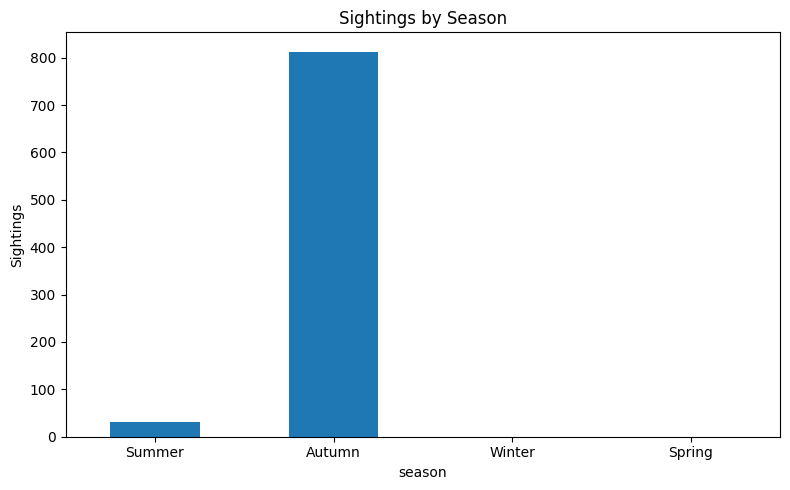

In [ ]:
# Ensure datetime format
df_cleaned['sighting_date'] = pd.to_datetime(df_cleaned['sighting_date'], errors='coerce')

# Map months to seasons
def get_season(date):
    if pd.isnull(date): return None
    month = date.month
    if month in [12, 1, 2]: return "Summer"
    elif month in [3, 4, 5]: return "Autumn"
    elif month in [6, 7, 8]: return "Winter"
    else: return "Spring"

df_cleaned['season'] = df_cleaned['sighting_date'].apply(get_season)

# Count sightings per season
season_counts = df_cleaned['season'].value_counts().reindex(['Summer', 'Autumn', 'Winter', 'Spring'])

# Plot
season_counts.plot(kind='bar', title="Sightings by Season", figsize=(8, 5))
plt.ylabel("Sightings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



**Compare Events (Little Things vs BioBlitz 2014 vs 2016)**

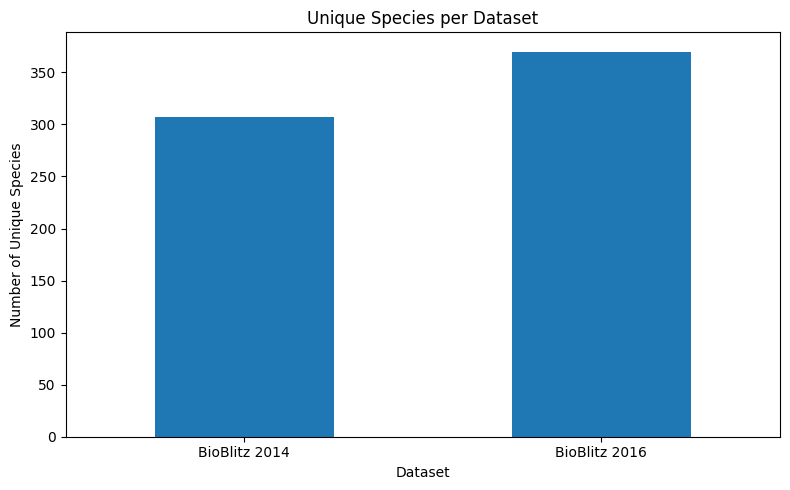

In [ ]:
# Count species by dataset
species_by_source = df_all.groupby('source')['species'].nunique().reset_index()
species_by_source.columns = ['Dataset', 'Unique Species Count']

# Plot
species_by_source.plot(x='Dataset', y='Unique Species Count', kind='bar', legend=False, title='Unique Species per Dataset', figsize=(8, 5))
plt.ylabel("Number of Unique Species")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
